## Introduction
The SENG 474 final project required us to collect, process, and mine data from any dataset. We decided on collecting data from the video game Defence of the Ancients 2 (referred to as Dota in this report). This section provides a basic outline of the structure of a typical Dota match to aid in the understanding of the data.

Dota is a multiplayer online battle arena (MOBA) game where two teams of five unique players compete to destroy structures. Each of the ten players in a match plays as a different hero. A hero is a character with at least 4 unique abilities and there are currently 117 unique heroes in Dota. The match takes place on a square map that is bisected diagonally from northwest to southeast. The two teams, named Radiant and Dire, each control one of these sections. The Dire controls the northeastern section and the Radiant controls the southwestern section. Each team has structures on their side of the map to help defend their base from the opposing team. A Radiant and Dire’s bases are located in the southwestern and northeastern corners of the maps, respectively. A structure called the Ancient is located in the center of each team’s base. The goal of Dota is to destroy they opposing team’s Ancient. Once a team destroys the opposing team’s Ancient, the game is over and the team that destroyed their enemy’s Ancient wins.
![](http://i.imgur.com/vbFqPpt.png)

**Fig 1 Overhead view of the map.**

Each player attempts to accumulate gold and experience through a variety of means to increase the strength of their hero. A hero’s strength increases by purchasing items with gold or levelling up a hero’s abilities by accumulating a certain amount of experience. The combined wealth of a hero, calculated by adding the value of their items and the amount of gold they possess, is known as the hero’s net worth. Throughout the course of a match heroes on opposing teams will fight and kill each other. A hero is only dead temporarily and will respawn after a certain length of time. The length of time is determined by the level of the hero who was killed. The total number of kills a team accumulates is known as their score. For example, a score of 23-15 means that Radiant has 23 kills and Dire has 15 kills.

To reach the enemy’s Ancient, a team must first destroy a number of other structures on their enemy’s side of the map. In general, the more structures a team has destroyed, the closer they are to reach their enemy’s Ancient. At the end of the game the team scores are not considered when determining the winner, the only goal is the destruction of the enemy’s Ancient.
![](https://i.ytimg.com/vi/D7BFF9o3FT4/maxresdefault.jpg)
**Fig 2 View of the Radiant Ancient from a player camera perspective.**

## Data Collection
This section covers our data collection process and the difficulties we faced. We created an automated data collection module using Python. The module is named `collect.py`. The module uses steampowered API to get the data from a Dota match that is passed to our processing module. `collect.py` uses the `GetMatchDetails` API call which returns a JSON object containing match statistics. The call requires two parameters, an API key and a `match_id`. The API key can be generated with a Steam account using the “Steam Community API registration page”[LINK?]. The `match_id` is unique to each game played. We used the website [Dotabuff](https://www.dotabuff.com) to find an initial `match_id`. We chose an arbitrary `match_id`s from a few years ago to ensure we would have enough data. In total we collected more 11,000 matches over the course of a few weeks.
```json
{
	"result": {
		"barracks_status_dire": 51,
		"barracks_status_radiant": 63,
		"cluster": 187,
		"dire_score": 75,
		"duration": 4253,
		"engine": 1,
		"first_blood_time": 37,
		"flags": 1,
		"game_mode": 22,
		"human_players": 10,
		"leagueid": 0,
		"lobby_type": 0,
		"match_id": 5000012945,
		"match_seq_num": 4193956416,
		"negative_votes": 0,
		"picks_bans": [
			{
				"hero_id": 62,
				"is_pick": false,
				"order": 0,
				"team": 0
			},
			{
				"hero_id": 1,
				"is_pick": false,
				"order": 1,
				"team": 0
			}
		],
		"players": [
			{
				"account_id": 1021944539,
				"assists": 20,
				"backpack_0": 0,
				"backpack_1": 0,
				"backpack_2": 0,
				"deaths": 16,
				"denies": 12,
				"gold_per_min": 621,
				"hero_id": 75,
				"item_0": 63,
				"item_1": 250,
				"item_2": 116,
				"item_3": 247,
				"item_4": 263,
				"item_5": 0,
				"kills": 19,
				"last_hits": 268,
				"leaver_status": 0,
				"level": 25,
				"player_slot": 0,
				"xp_per_min": 599
			},
			…
		]
	}
}
```
**Fig 3 Example of a condensed single match json object.**

The `get_match` method in `collect.py` is responsible for making the API call and collecting the JSON data. In this method, the initial `match_id` value is incremented in a loop to obtain new matches. Each of these datasets are then written to a temporary file before being moved to the `raw_data.json` file. This transfer process is necessary because the objects returned are single match results rather than a list of matches.

During our data collection process we faced challenges with the API. Initially, we were using the API call `GetMatchHistory`, which returns the most recent 100 public matches as a JSON list. However, we quickly found that this was restricting, as we could not go further back in time than 200 matches. This meant we had to constantly ping for data in a loop while removing duplicate matches. This form of collection was too slow so we employed a different strategy.

## Pre-processing
All the data output by `collect.py` is relevant when considering a match, but for the purposes of this project some data had to be pruned. Given our understanding of the game, we tried to isolate the most important data points available to us:
- Player gold
- Player experience
- Player hero
- Team score
- Team structure destruction
- Match duration
- Radiant victory status

In this project we process the data from Radiant’s perspective. Most of the data output by our processing module is a difference between the Radiant and Dire. We chose this format to better illustrate the performance of the Radiant team in the match.

### Filtering Raw Data
Not all of the data collected was usable. There are cases where matches were disconnect during the hero picking phase or crashed due to server issues. These cases manifest themselves as match result JSON objects that do not contain the win metric, `radiant_win`. Since we are mostly interested in the result of the matches, these instances were not used. Furthermore, there are some instances where player statistics are all `0`, this includes attributes such as `hero_id`. We do not have an explanation for this behaviour but, since a `hero_id` of `0` is invalid, the entire match is invalid.

A filtering method loops over the entire dataset searching for these two cases and removing them. In the end we have X% of matches that were invalid.

```python
def filter_bad_data(data):
	matches = []
	for match in data:
		if 'radiant_win' in match['result'].keys():
			for player in match['result']['players']:
				if player['hero_id'] > 0:
					matches.append(match)
					
	return matches
```
**Fig 4 Bad data filtering method.**

### Per Minute Metrics
Economy and experience are widely considered to be the most important factors for victory. As explained above, a player's net worth is an attribute that quantifies their economic standing in a match. Experience is strongly valued as it increases a hero’s strength and is generally gained at the same rate that a player earns gold. Strangely, neither of these values are included as a part of the API response. Instead, we are given each players gold per minute and experience per minute values. Using these values, we can approximate net worth and net experience.

Since we know the duration of a match we can use these per minute metrics in a method that will approximate a player's total gold and experience. Once the totals are calculated we subtract Radiant `net_worth` and `net_xp` from the Dire counterparts.
```python
def calculate_per_min_metrics(team_roster, duration, metric):
	metric_total = 0
	
	for player in team_roster:
		mps = float(player[metric]) / float(60)
		metric_total += (mps * duration)
		
	return metric_total
```
**Fig 5 An example of the calculation method.**

### Hero Win Rates
Before a match begins, each player has the opportunity to choose their hero from the hero pool. Naturally, some of these heroes are stronger than others. In order to quantify this, we wanted to calculate the win rate of each of the heroes.

To do this we used another steampowered API call named `GetHeroes`. This call returns a JSON list of the hero names and their IDs. This list is then used along with the match data by the `get_hero_winrates` method. The method iterates over each of the heroes, filters the entire dataset for matches that contained the hero, and determines whether the hero was on the winning side. Wins are tallied and divided by the number of matches, returning a percentage. The output is a dictionary with the `hero_id` and their `winrate`. This output is then used to determine each team’s average hero win rate. A difference is taken between the teams as the final output.
```python
def get_hero_winrates(data, hero_file):
	heroes = read_file(hero_file)
	winrates = {}
	for hero in heroes['result']['heroes']:
		hero_data = filter_by_hero(data, hero['id'])
		wins = 0
		for match in hero_data:
			if did_hero_win_match(match, hero['id']):
				wins += 1
						
		winrates[hero['id']] = calculate_win_percent(len(hero_data), wins)

	return winrates
```
**Fig 6 Hero win rate calculation method.**

### Structures
Barracks are structures within a team’s base that automatically spawn nonplayer characters (known as Creeps) at fixed intervals who fight for their respective team. There are six Barracks in each team’s base. Destroying an enemy’s Barracks will increase the strength of the Creeps spawning from the other team’s Barracks. For example, if Radiant destroy a Barracks of the Dire, Radiant will have stronger Creeps to aid them in their ultimate push towards the Dire’s Ancient. Therefore, the more of the enemy’s Barracks a team destroys, the easier the push for further objectives becomes.

Barracks are represented by 8 bit unsigned integers in the JSON output. The first two leftmost bits are irrelevant. Starting with the third leftmost bit the bits represent whether a Barracks is standing (`1`) or has been destroyed (`0`).
```python
def get_number_of_standing_buildings(status):
	status = bin(status)
	buildings_alive = 0
	for building in status:
		if building == '1':
			buildings_alive += 1
			
	return buildings_alive
```
**Fig 7 Structure status code.**

### Trivial Data Processing
Some of the data collected needed minimal processing. Examples are `score`, `duration`, and `radiant_win`. Each of these existed in the JSON file on their own and were simply extracted. In the case of `score` the opposing teams scores were subtracted from one another.

### Final Output
The final output of the data processing module are two CSV files. One containing 100 rows of test data and the other containing over 11,000 rows of test data. These files are created by `build_csv.ipynb` using the `process.py` module.
```
net_worth | net_xp | team_winrate_avg | score | net_barracks | duration | radiant_win
----------+--------+------------------+-------+--------------+----------+------------
16799.35  | -70.88 |       -2.43      |   -3  |       2      |   4253   |    True
```
**Fig 8 Example of the csv output.**

## Visualization
To help visualize some of the data we have collected we can use plots.

In [2]:
import pandas

train_data = pandas.read_csv('../data/training_data.csv', sep=',', header=0)
test_data = pandas.read_csv('../data/testing_data.csv', sep=',', header=0)

X_train = train_data.iloc[:, 0:6]
X_test = test_data.iloc[:, 0:6]

y_train = train_data.iloc[:, -1]
y_test = test_data.iloc[:, -1]

In [3]:
# Get win/loss data
win = test_data[test_data.radiant_win == True]
loss = test_data[test_data.radiant_win == False]

data = (win, loss)
colours = ('blue', 'red')
groups = ('Wins', 'Losses')

### A note to the marker:
Every plot should be as large as this page. Some of the plots may render smaller at first, but, if you run the cell again, the plot will resize appropriately. Thank you!

### Score x Duration Plot
The plot below looks at `score` and `duration` and their relationship to winning.  We can see that victories and defeats bunch together between `2000` and `3000` seconds.  Within this subset we see that larger differences in score are more likely to produce a positively correlated result. Meaning, if a team has a higher score, they win. However, as we move beyond the `3000` second mark, we find that the score becomes less important. Wins and losses scatter across the `0` mark more so than they do earlier in the game. Therefore, as the game goes on teams find ways to win that do not have to include directly killing enemies.

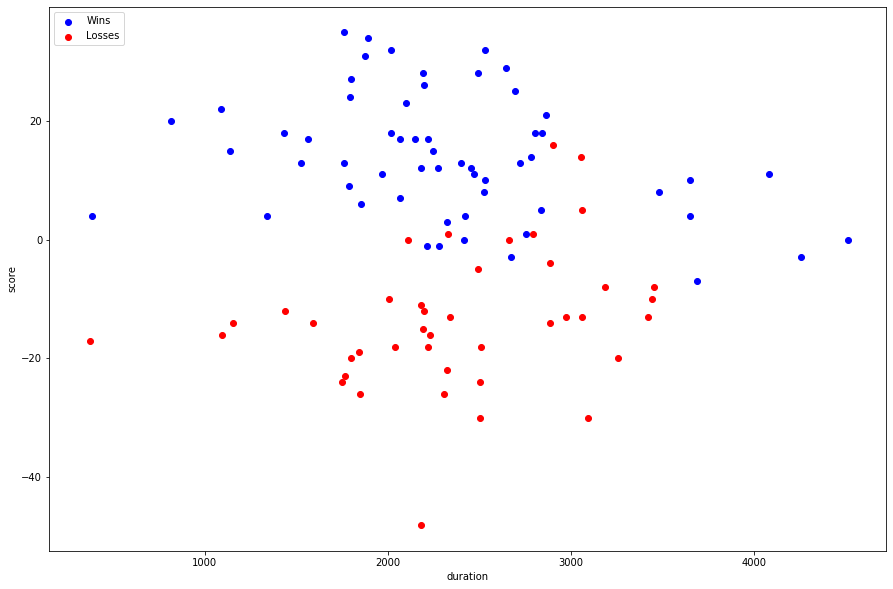

In [16]:
import matplotlib.pyplot as plt
from IPython.display import display

'''FOR THE MARKER:

   This cell may need to be run twice to show the plot.
   If you do not see a plot in immediately below this
   cell, please run this cell again!
'''

# Create plot
x_val = 'duration'
y_val = 'score'

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for datum, colour, group in zip(data, colours, groups):
    x = datum[x_val]
    y = datum[y_val]
    ax.scatter(x, y, c=colour, label=group)
    
# plot
plt.rcParams['figure.figsize'] = (15, 10)
plt.title('')
plt.legend(loc=2)
plt.xlabel(x_val)
plt.ylabel(y_val)
plt.show()

### Net Barracks x Duration Plot
To examine the theory that objectives such as structures are more important than kills, we created the plot below. This plot shows us `net_barracks` and `duration` in relation to winning, similar to the plot above. The plot shows us that in almost all cases, if a team has a structural advantage they win the match. Interestingly enough, there are no cases where the `net_barracks` value was`0` meaning this scenario is very rare. 

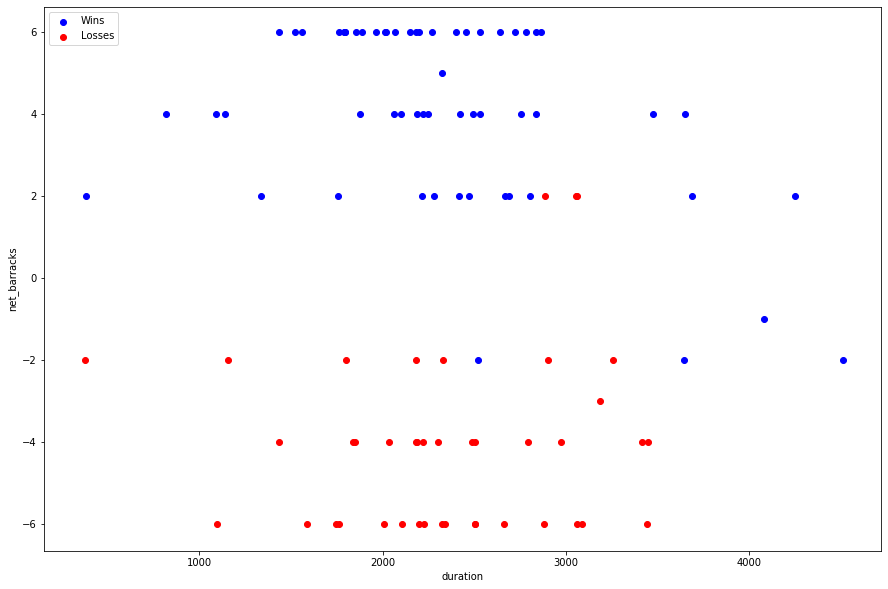

In [15]:
# Create plot
x_val = 'duration'
y_val = 'net_barracks'

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for datum, colour, group in zip(data, colours, groups):
    x = datum[x_val]
    y = datum[y_val]
    ax.scatter(x, y, c=colour, label=group)
    
# plot
plt.rcParams['figure.figsize'] = (15, 10)
plt.title('')
plt.legend(loc=2)
plt.xlabel(x_val)
plt.ylabel(y_val)
plt.show()

### Team Winrate Average x Duration Plot
One of our assumptions at the start of this project was that hero win rates would play a part in the outcome of a match. To examine this, we placed `team_winrate_avg` and `duration` into a plot below. More so than either of the plots before, the results here are scattered. Even though the hero win rates range from approximately +/-4% there is no discernible correlation between win rate and winning in this context. It is far more likely that the result of a match is determined by kills or objectives.

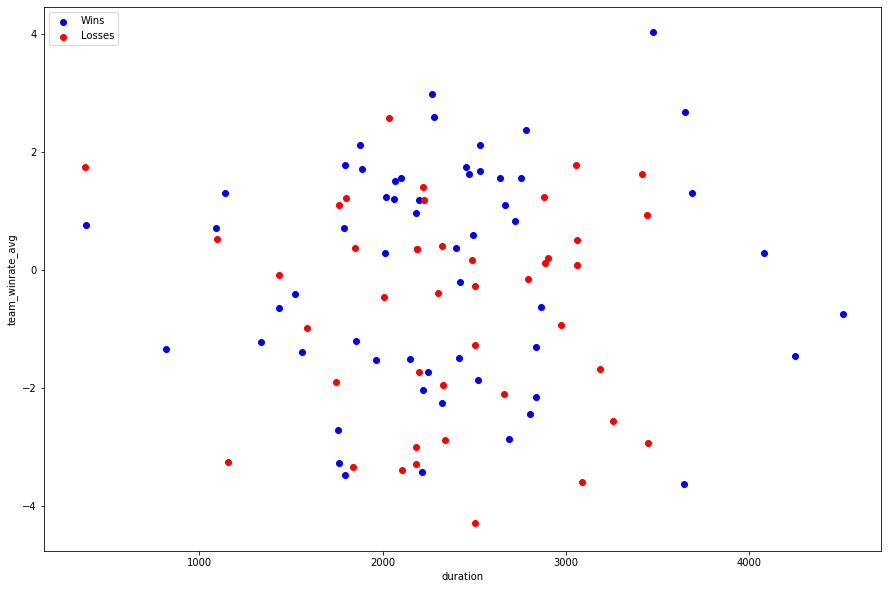

In [6]:
# Create plot
x_val = 'duration'
y_val = 'team_winrate_avg'

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for datum, colour, group in zip(data, colours, groups):
    x = datum[x_val]
    y = datum[y_val]
    ax.scatter(x, y, c=colour, label=group)
    
# plot
plt.rcParams['figure.figsize'] = (15, 10)
plt.title('')
plt.legend(loc=2)
plt.xlabel(x_val)
plt.ylabel(y_val)
plt.show()

## Data Mining

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from IPython.display import display
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, plot_tree
from modules import process as prc

### Bernoulli
Given the match statistics, we want to predict whether or not Radiant won the match. To do this we use Naive Bayes class prediction. The code in the **Visualization** section split both the training and testing data sets from their `radiant_win` class.  This gives us the variables `X_train`, `y_train`, `X_test` and `y_test`. First, we train the model using the training data, `X_train` and `y_train`. Then we predict `X_test` with the output being placed into `y_pred`. Finally, we use our accuracy scoring method to output the accuracy of the predictions.

In [8]:
# Bernoulli
BernNP = BernoulliNB(binarize = True)
BernNP.fit(X_train, y_train)

y_pred = BernNP.predict(X_test)
print(prc.accuracy_score(y_pred, y_test))

96.0


The accuracy is 96.0%, telling us that given the match statistics we can almost always determine who won. Given our experiences with the game we can say that generally a team knows when they are going to lose due to the advantages in objectives, net worth, and score. This is reflected in our findings here.

### ID3
To visualize the logic of a predictive model we can use the ID3 algorithm. This algorithm uses the entropy of attributes to construct a decision tree. Below, we fit the decision tree using `X_test` and `y_test`. These were selected in favour of the training data because the tree output by the 10,000+ rows was too large to display in a Jupyter Notebook. Therefore, we decided to use the testing data which is only 100 rows.

[Text(418.5, 475.65000000000003, 'net_worth <= -1522.192\nentropy = 0.981\nsamples = 100\nvalue = [42, 58]'),
 Text(209.25, 339.75, 'net_xp <= 17552.25\nentropy = 0.165\nsamples = 41\nvalue = [40, 1]'),
 Text(104.625, 203.85000000000002, 'entropy = 0.0\nsamples = 40\nvalue = [40, 0]'),
 Text(313.875, 203.85000000000002, 'entropy = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(627.75, 339.75, 'net_worth <= 2953.842\nentropy = 0.214\nsamples = 59\nvalue = [2, 57]'),
 Text(523.125, 203.85000000000002, 'net_worth <= 1642.225\nentropy = 0.971\nsamples = 5\nvalue = [2, 3]'),
 Text(418.5, 67.94999999999999, 'entropy = 0.0\nsamples = 3\nvalue = [0, 3]'),
 Text(627.75, 67.94999999999999, 'entropy = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(732.375, 203.85000000000002, 'entropy = 0.0\nsamples = 54\nvalue = [0, 54]')]

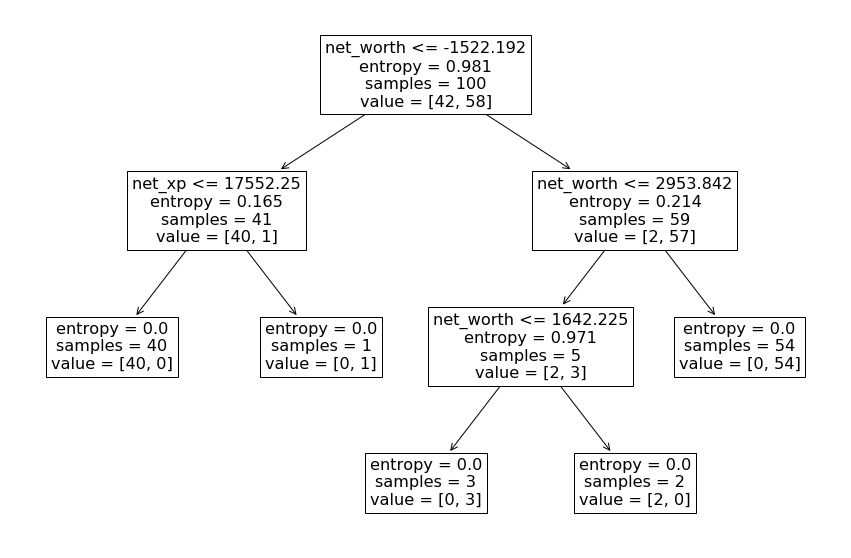

In [9]:
# ID3
dTree = DecisionTreeClassifier(criterion='entropy')
dTree.fit(X_test, y_test)
display(plot_tree(dTree, feature_names=X_train.keys().values))

Examining this tree we find some interesting details. Three of the four decision nodes use `net_worth` as their determining variable. This tells us that, in the end, a team’s economy is the most important factor in the game. The first node has a very high entropy value of 0.981. Therefore we can interpret this as any game within approximately 1500 net worth is considered a close game. This point is further supported by the third decision node on the right branch of the tree. There we find that a `net_worth` between approximately -1500 and approximately +1600 leads to an entropy value of 0.971.

### Logistic Regression
In this section we run a Logistic Regression on our data. The algorithm was able to correctly model the probability of Radiant winning a match 97% of the time. The `.predict` function returns a list of predicted classes, while `.score` returns the mean accuracy on the given data.

In [10]:
# Logistic Regression
logmodel = LogisticRegression(solver='liblinear')
logmodel.fit(X_train,y_train)

pred = logmodel.predict(X_test)

print(logmodel.score(X_test, y_test))

0.97


### Confusion Matrix
Here we calculate the true positive, false positive, true negative, and false negative values between our predicted outcome and the actual outcome of a match. We also calculate precision and recall. Precision tells us what was correctly guessed as positive. Recall tells us the proportion of losses predicted as losses.

In [11]:
# Confusion Matrix

# True Positive (correctly predicted a win)
true_pos = 0
# False Positive (incorrectly predicted a win)
false_pos = 0
# True Negative (correctly predicted a loss)
true_neg = 0
# False Negative (incorrectly predicted a loss)
false_neg = 0

for i, j in zip(pred, y_test):
    if i == True and j == True:
        true_pos += 1
    elif i == True and j == False:
        false_pos += 1
    elif i == False and j == False:
        true_neg += 1
    elif i == False and j == True:
        false_neg += 1
    else:
        print('Prediction mistake?')
    
# Precision = TP / (TP+FP) = Correctly guessed positive
precision = true_pos / (true_pos + false_pos)
# Recall = TP / (TP+FN) = Proportion of losses predicted as losses
recall = true_pos / (true_pos + false_neg)
    
print('True positive: {}'.format(true_pos))
print('False positive: {}'.format(false_pos))
print('True negative: {}'.format(true_neg))
print('False negative: {}'.format(false_neg))
print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))

True positive: 57
False positive: 2
True negative: 40
False negative: 1
Precision: 0.9661016949152542
Recall: 0.9827586206896551


### K-Means
K-Means is an algorithm that forms clusters of data based on similarity between data instances. It clusters data based on the Euclidean distance between data points. We chose to visualize three clusters between the data points on the plot. Both plots contain centroid points for each cluster.

The KMeans clustering plot below depicts match duration on the x-axis and match score on the y-axis. The clusters are mostly demarcated along the y-axis. This shows that the difference in score tends to be largest in matches that run between `2000` and `3000` seconds.

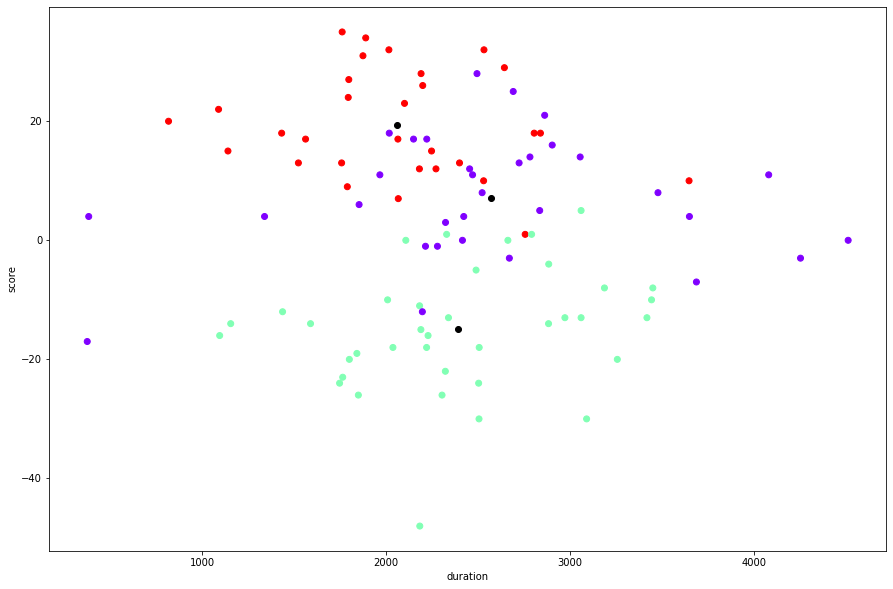

In [14]:
# K-Means

X = X_test.to_numpy()

kmeans = KMeans(n_clusters=3).fit(X)
# Columns in the dataset (1 indexing):
# net_worth, net_xp, team_winrate_avg, score, net_barracks, duration, radiant_win
columnA = 5
columnB = 3

col_names = X_train.columns.values
colA_name = col_names[columnA]
colB_name = col_names[columnB]

prediction = kmeans.predict(X_test) # predict to which cluster each row in X_test belongs. Neat!

plt.xlabel(colA_name)
plt.ylabel(colB_name)

plt.scatter(X[:,columnA],X[:,columnB], c=kmeans.labels_, cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:,columnA] ,kmeans.cluster_centers_[:,columnB], color='black')

The KMeans clustering plot below depicts match duration on the x-axis and match net experience on the y-axis. This shows that the difference in net experience tends to be largest in matches that run between `2000` and `3000` seconds.

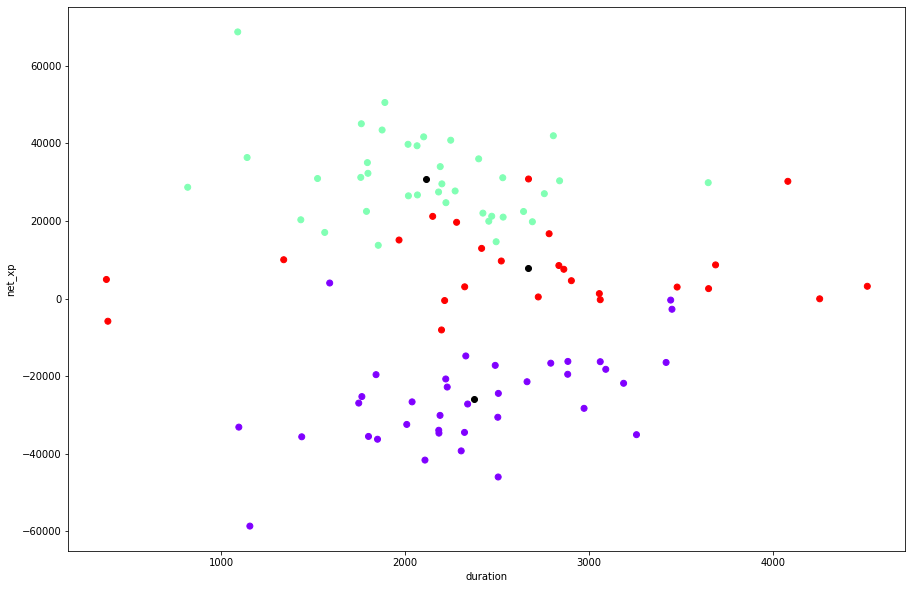

In [13]:
columnA = 5
columnB = 1
colA_name = col_names[columnA]
colB_name = col_names[columnB]
plt.xlabel(colA_name)
plt.ylabel(colB_name)
plt.scatter(X[:,columnA],X[:,columnB], c=kmeans.labels_, cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:,columnA] ,kmeans.cluster_centers_[:,columnB], color='black')

## Conclusion
In this project we examined Dota match data. We found that team economy is the driving force of the game. Almost always the team with the significant net worth advantage will win the game. Furthermore, we found that most games are decided between the `2000` and `3000` second mark. The matches falling within this subset are generally decisive with large spreads in the team’s statistical success. These findings may no longer be accurate. The most effective heroes and tactics in Dota are constantly changing due to updates to the game. The data we collected was from several years ago and may not necessarily reflect the state of the game now.

We found the process of collecting and processing data exhilirating. We enjoyed writing functions that automated these tasks. During the course of this project we attained a respect for the many ways data can be used to help further the understanding of a particular topic. Overall, our enthusiasm for data increased and we look forward to using the knowledge of this class in personal projects.
